# 1️⃣ **Analysis of polymers sales**

**Task**: train a few base algorithms

**Models:**
- `Sarimax`
- `Propthen ETNA`
- `Catboost ETNA`


✅ The following will be implemented:
- all additional conditions
- framework capabilities (loading of datacets with corresponding classes, correct preparation of categorical features, early_stopping, multithreading)
- hyperparameter selection for each model

## Импорт необходимых библиотек

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import copy
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mean_absolute_percentage_error as MAPE

In [3]:
import warnings
warnings.filterwarnings(action="ignore", message="Torchmetrics v0.9")

In [4]:
!pip install etna

^C


In [ ]:
from etna.datasets.tsdataset import TSDataset

In [ ]:
from etna.models import ProphetModel
from etna.metrics import MAE, MSE, MAPE
from etna.analysis import plot_forecast

In [ ]:
from pmdarima import auto_arima

In [ ]:
random.seed(42) # фиксируем воспроизводимость
%matplotlib inline

## 1. Делаем краткий EDA данных

In [6]:
data = pd.read_csv(r'C:\Users\yusup\OneDrive\Рабочий стол\Demand_ forecast\data\raw\sc2021_train_deals.csv', parse_dates=["month", "date"])
data.head()

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,date,volume
0,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-01,43.0
1,197,0,Китай,Китай,16350,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,95.0
2,794,2162,Казахстан,Атырауская обл.,10942,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,2018-01-02,57.0
3,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,21.0
4,133,0,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,150.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92306 entries, 0 to 92305
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   material_code       92306 non-null  int64         
 1   company_code        92306 non-null  int64         
 2   country             92306 non-null  object        
 3   region              92306 non-null  object        
 4   manager_code        92306 non-null  int64         
 5   month               92306 non-null  datetime64[ns]
 6   material_lvl1_name  92306 non-null  object        
 7   material_lvl2_name  92306 non-null  object        
 8   material_lvl3_name  92306 non-null  object        
 9   contract_type       92306 non-null  object        
 10  date                92306 non-null  datetime64[ns]
 11  volume              92306 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 8.5+ MB


In [ ]:
# временной диапазон выборки
min_date = data['date'].dt.strftime('%Y-%m-%d').min()
max_date = data['date'].dt.strftime('%Y-%m-%d').max()
min_date, max_date

('2018-01-01', '2020-07-31')

<Axes: xlabel='date'>

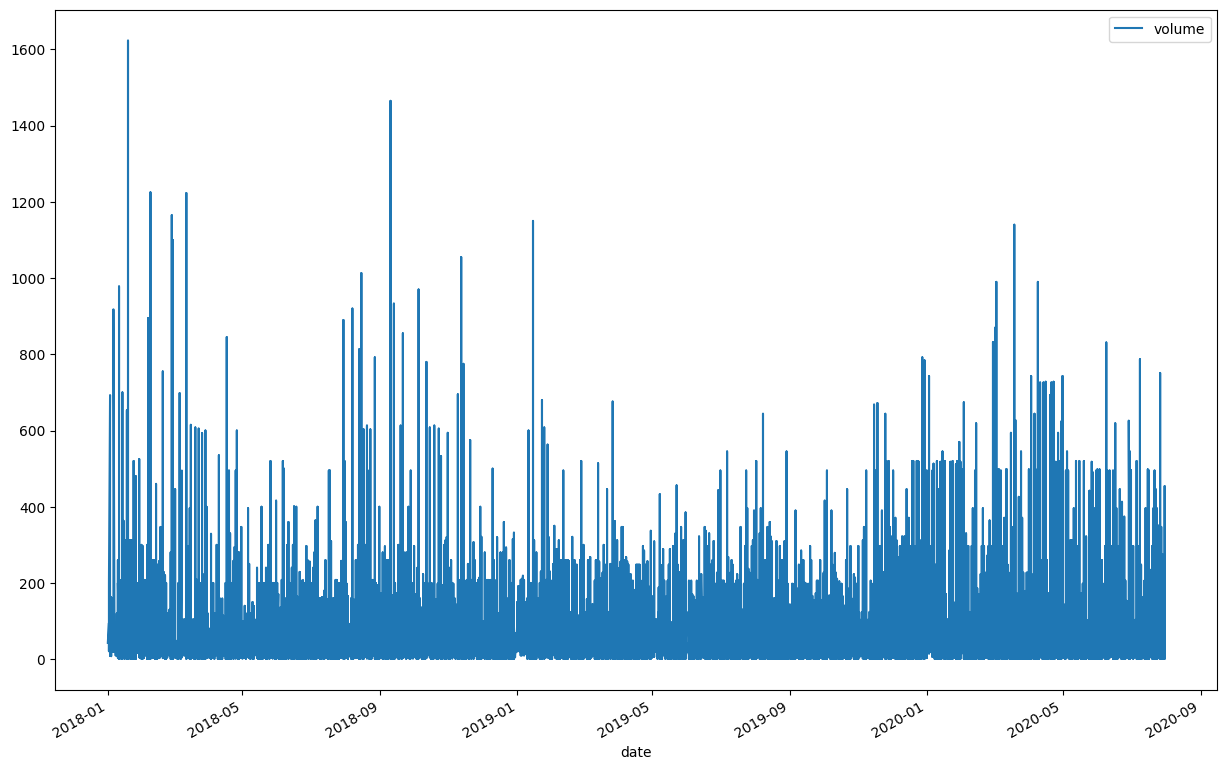

In [ ]:
data.plot(x = "date", y = "volume", figsize = (15,10))

### Сгруппируем по месяца

<Axes: xlabel='month'>

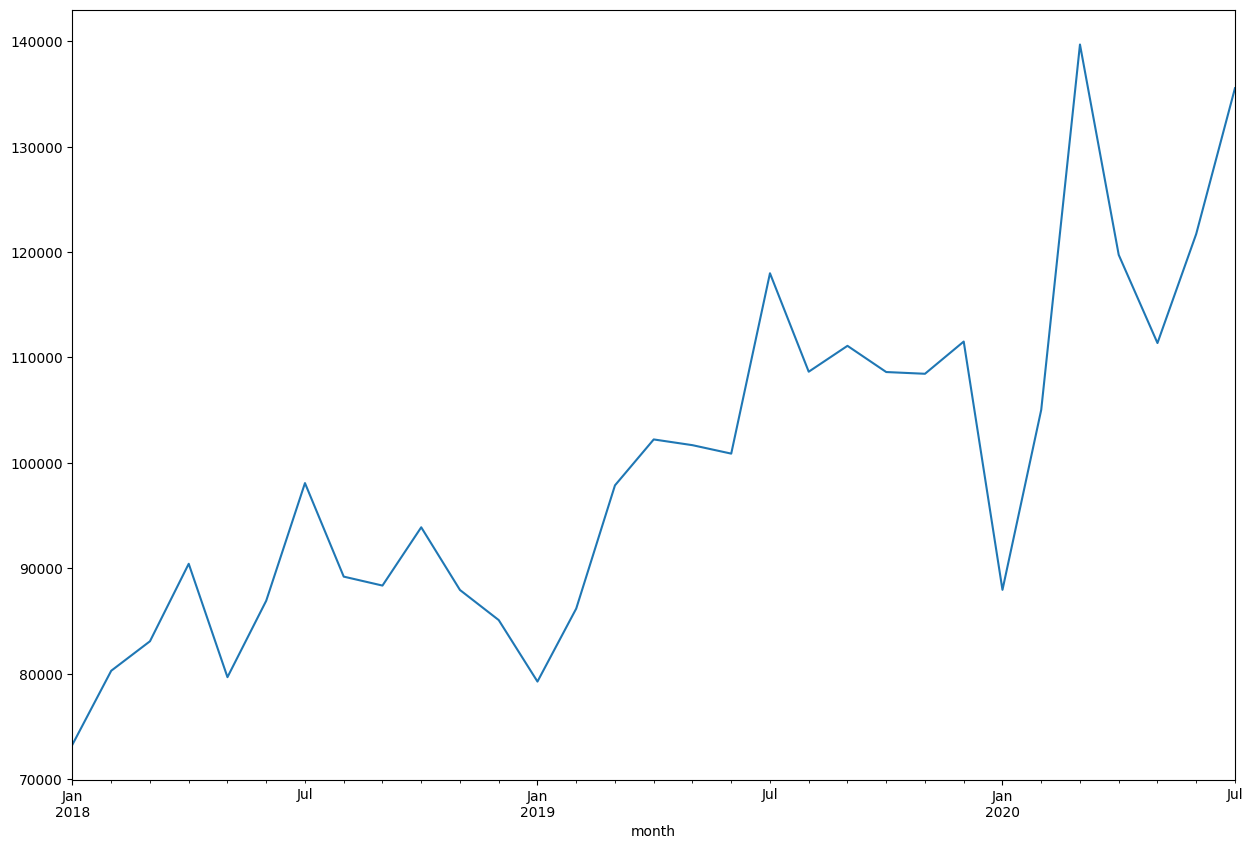

In [ ]:
data.groupby(["month"])["volume"].sum().plot(x = "month", y = "volume", figsize = (15,10))

## Раскладываем на компоненты

<Figure size 640x480 with 0 Axes>

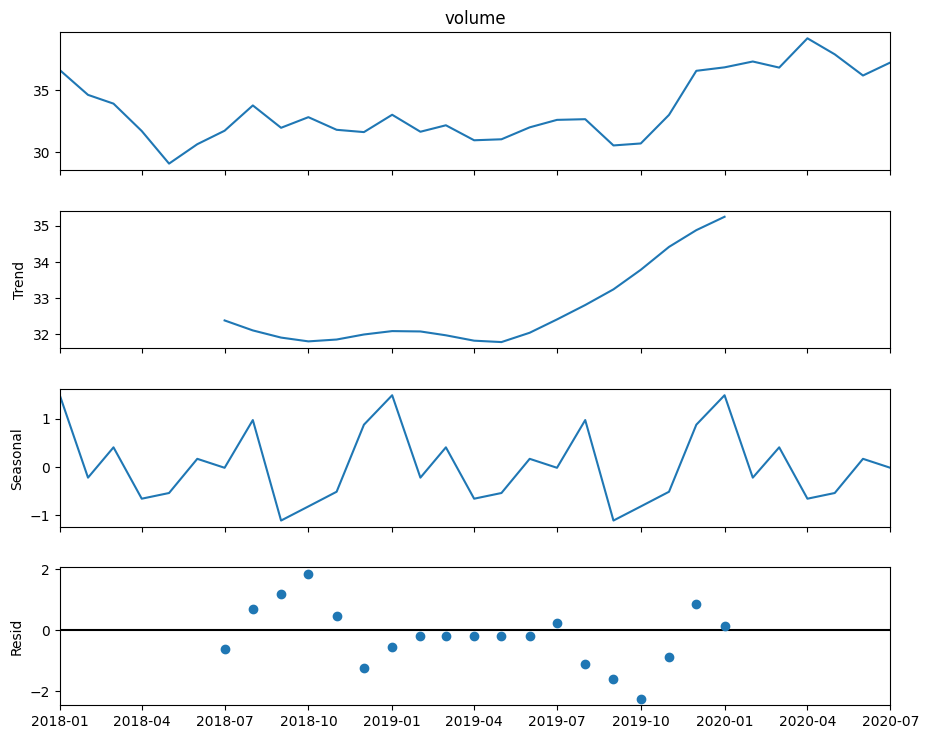

In [ ]:
train_plot = data.set_index('date')
y = train_plot['volume'].resample('MS').mean()

result = sm.tsa.seasonal_decompose(y, model='additive')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(10, 8)

## Проверяем на стационарность посредство теска Дики-Фуллера

In [ ]:
## функция проверки
def test_stationarity(timeseries):
    # Определяем статистики
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Проводим тест Дики-Фуллера
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Определение стационарности на основе p-value и других метрик
    if dfoutput['p-value'] <= 0.05 and dfoutput['Test Statistic'] < dfoutput['Critical Value (1%)']:
        print("Ряд стационарен")
    else:
        print("Ряд нестационарен")

Results of Dickey-Fuller Test:


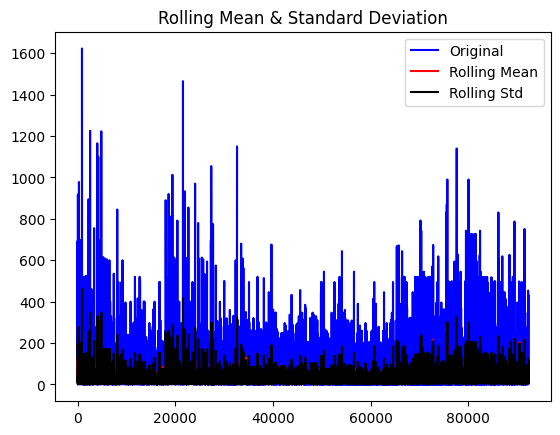

Ряд стационарен


In [ ]:
test_stationarity(data['volume'])

In [ ]:
## дополнительный тест
def check_stationarity(time_series):
    # Вычисление скользящего среднего и стандартного отклонения
    rolling_mean = time_series.rolling(window=7).mean()
    rolling_std = time_series.rolling(window=7).std()

    # Проверка на постоянство среднего и дисперсии
    if np.allclose(rolling_mean, rolling_mean.mean()) and np.allclose(rolling_std, rolling_std.mean()):
        print("Ряд стационарен")
        return True
    else:
        print("Ряд нестационарен")
        return False

In [ ]:
is_stationary = check_stationarity(data['volume'])


Ряд нестационарен


#### Формально тест Дикки-Фуллера показывает, что ряд стационарен, так как по значению p-value меньше 0.05. DF значение по модулю меньше критического значения. Однако, визуально видно, что ряд не стационарен. Это также потверждается тестом на стационарность методом скользязих средних и дисперсии. Для первичной итерации и построения baseline принимаем что ряд стационарен

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

### Выведем график автокорреляции и частичной автокорреляции

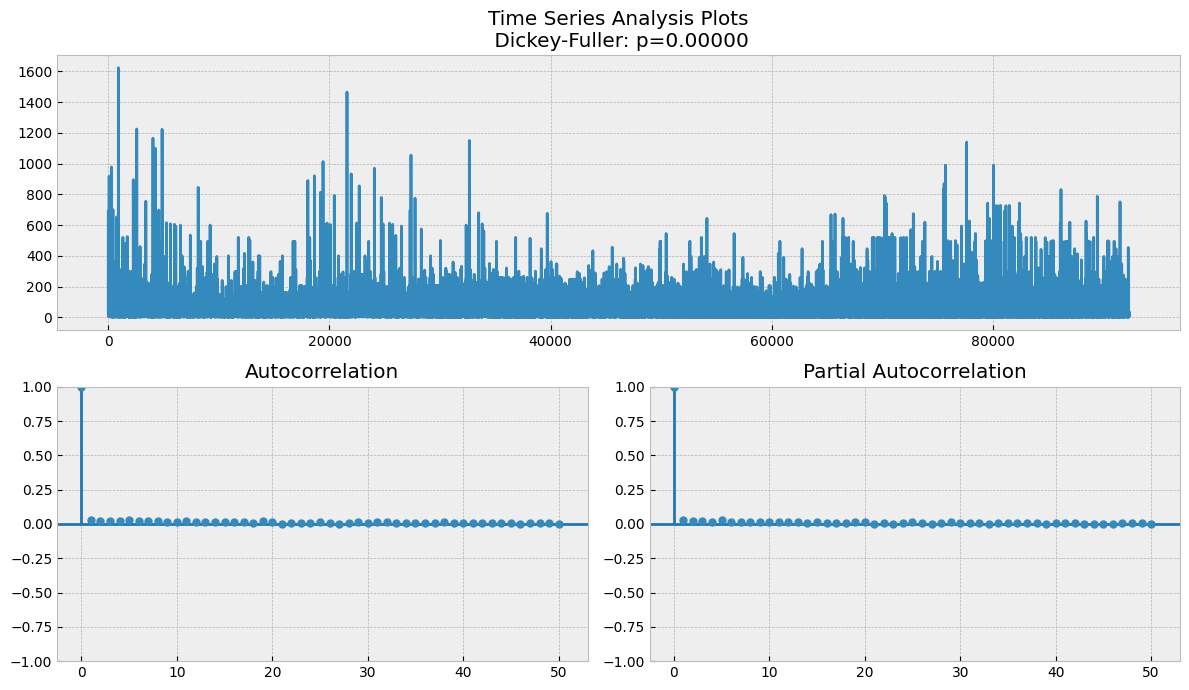

In [ ]:
tsplot(data['volume'])

## В случе, если точки ACF и PACF близки к нулю, можно предположить что временной ряд близок к белому шуму. Вместе с тем дкпомнозиция показала, что продажи имеют сезонность и тренд

# 2. Строим модель SARIMAX

In [ ]:
train_plot.head()

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,volume
date,,,,,,,,,,,
2018-01-01,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,43.0
2018-01-02,197,0,Китай,Китай,16350,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,95.0
2018-01-02,794,2162,Казахстан,Атырауская обл.,10942,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,57.0
2018-01-02,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,21.0
2018-01-02,133,0,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,150.0


## Ресемплируем данные и сделаем средние по неделям

In [ ]:
df = train_plot.resample(rule = 'w').mean()
df.head()


<ipython-input-68-d70dfc5c5639>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = train_plot.resample(rule = 'w').mean()


,material_code,company_code,manager_code,volume
date,,,,
2018-01-07,332.554217,3629.554217,15328.048193,55.746988
2018-01-14,385.481375,3894.573066,14687.045845,37.730659
2018-01-21,412.317604,3543.433757,14581.083485,39.874773
2018-01-28,391.107903,3428.413374,14889.969605,32.554711
2018-02-04,402.558416,3531.603960,14888.621782,33.225743


<Axes: xlabel='date'>

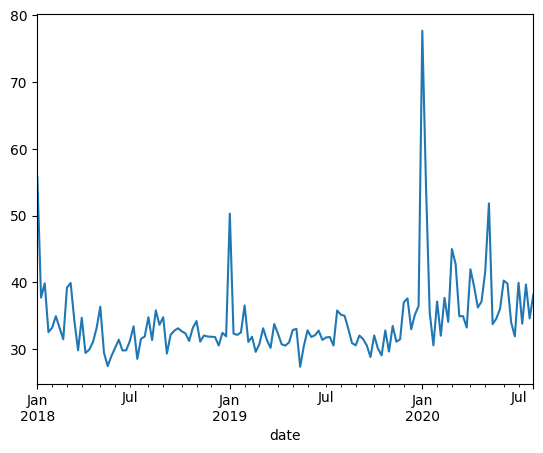

In [ ]:
df['volume'].plot()

### Тестируем на стационарность

Results of Dickey-Fuller Test:


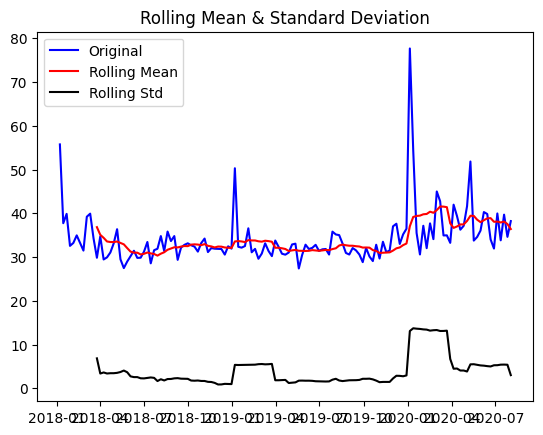

Ряд стационарен


In [ ]:
test_stationarity(df['volume'])

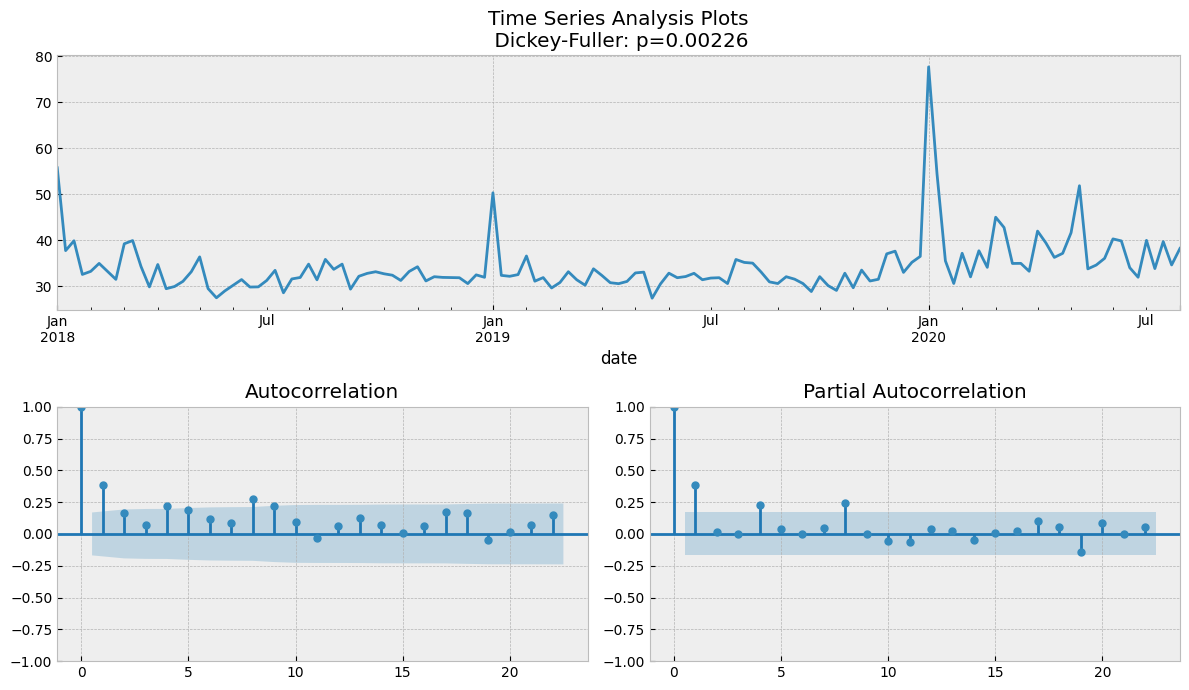

In [ ]:
tsplot(df['volume'])

### Сглаженные недельные средние показывают более менее адекватные графики AFC и PACF. Обратим внимание на 2, 5, 8, 13 и пр. в графике AFC. PACF ничего особенного не выявили

In [ ]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.3-py3-none-any.whl size=190251 sha256=1a10c7bc0737b56101bebc001a6e873fd96958f1192e2693220028788ae352f1
  Stored in directory: /root/.cache/pip/wheels/05/f8/db/124d43bec122d6ec0ab3713fadfe25ebed8af52ec561682b4e
Successfully built pyod


In [ ]:
from statsmodels.robust.scale import mad
from sklearn.ensemble import IsolationForest

def detect_and_plot_anomalies(df, column_name):
    """
    Detects anomalies in a time series using Isolation Forest and plots them on a graph.

    Args:
        df (pd.DataFrame): DataFrame containing time series data.
        column_name (str): Name of the column containing the time series values.

    Returns:
        None
    """
    # Calculate MAD
    mad_value = mad(df[column_name])

    # Fit Isolation Forest model
    model = IsolationForest(contamination=0.05)  # Adjust contamination parameter as needed
    model.fit(df[[column_name]])

    # Predict anomalies
    df["IsAnomaly"] = model.predict(df[[column_name]])

    # Create a plot
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[column_name], label="Временной ряд")
    plt.scatter(df.index[df["IsAnomaly"] == -1], df[column_name][df["IsAnomaly"] == -1], color="red", label="Аномалии")
    plt.xlabel("Время")
    plt.ylabel("Значение")
    plt.title(f"Временной ряд с аномалиями ({column_name})")
    plt.legend()
    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


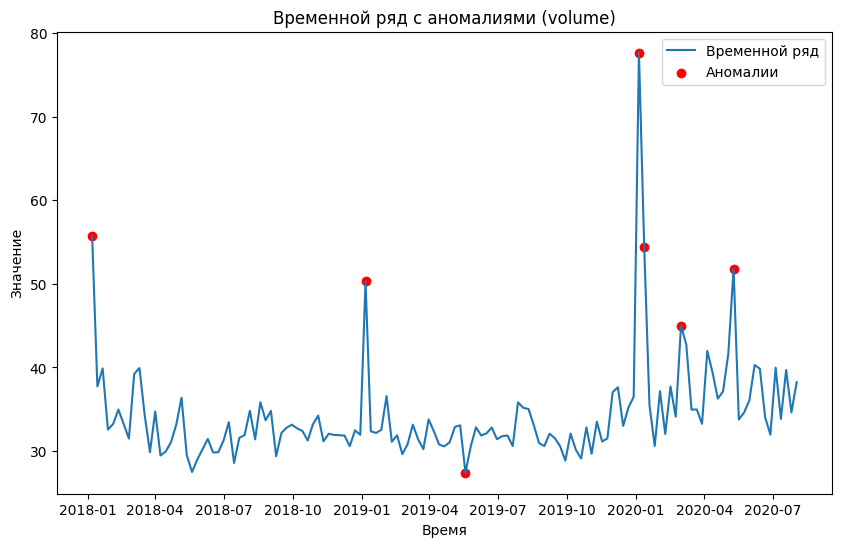

In [ ]:
detect_and_plot_anomalies(df, column_name='volume')

### На текущем этапе не будем удалять предложенные случайным лесом аномалии для первичной итерации

## 2.1 Подготовка данных для модели Sarimax

In [ ]:
key_cols = ['material_code',	'company_code',	'manager_code']

In [ ]:
df.drop(key_cols, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135 entries, 2018-01-07 to 2020-08-02
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  135 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


### Разделяем на тестовую и тренировочную выборку



In [ ]:
train_eval = df[:-33]
test_eval = df[-33:]
print(f"Количество недель в тренировочной выборке: {len(train_eval)}")
print(f"Количество недель в тестовой выборке: {len(test_eval)}")

Количество недель в тренировочной выборке: 102
Количество недель в тестовой выборке: 33


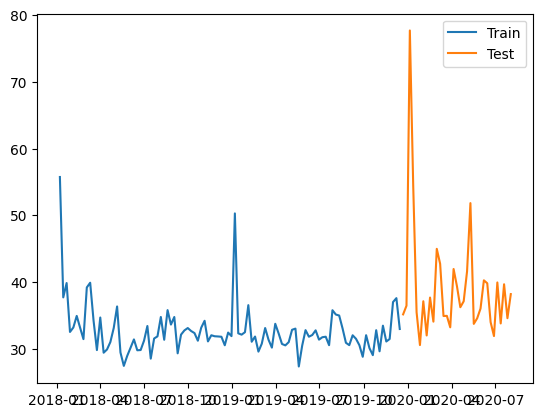

In [ ]:
plt.plot(train_eval['volume'], label='Train')
plt.plot(test_eval['volume'], label='Test')
plt.legend()

## Подбор параметров для SARIMA. В бизнес-сценариях, таких как планирование запасов или прогнозирование спроса, важно учитывать годовой цикл. Например, перед праздничным сезоном или сменой времени года спрос на определенные товары может значительно измениться. Сезонность с периодом в 52 недели помогает уловить эти тренды.

In [ ]:
auto_arima(train_eval['volume'], seasonal = True, m=52)

ARIMA(order=(0, 0, 2), scoring_args={}, seasonal_order=(1, 0, 0, 52),
      suppress_warnings=True)

## 2.2 Обучение и оценка базовой модели SARIMAX

In [ ]:
model_sarima = SARIMAX(train_eval['volume'],order=(0,0,2),seasonal_order=(1,0,0,52)).fit()

In [ ]:
start=len(train_eval)
end=len(train_eval)+len(test_eval)-1
pred_sarima = model_sarima.predict(start=start, end=end, dynamic=False)

In [ ]:
print("MAE:", MAE(pred_sarima, test_eval['volume']))
print("RMSE:", MSE(pred_sarima, test_eval['volume'])**0.5)
print("MAPE:", MAPE(pred_sarima, test_eval['volume']))

MAE: 7.528922018459695
RMSE: 9.837485352556321
MAPE: 0.2347153630576069


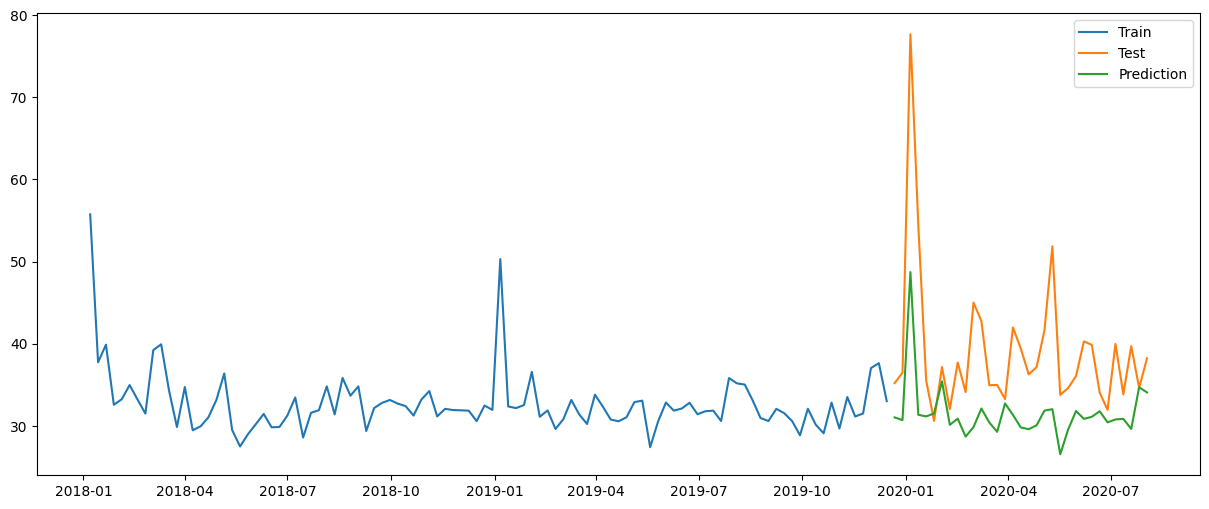

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(train_eval['volume'], label='Train')
plt.plot(test_eval['volume'], label='Test')
plt.plot(pred_sarima, label='Prediction')
plt.legend()

In [ ]:
print(model_sarima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              volume   No. Observations:                  102
Model:             SARIMAX(0, 0, 2)x(1, 0, [], 52)   Log Likelihood                -348.213
Date:                             Fri, 01 Mar 2024   AIC                            704.426
Time:                                     10:10:43   BIC                            714.926
Sample:                                 01-07-2018   HQIC                           708.678
                                      - 12-15-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8728      0.095      9.218      0.000       0.687       1.058
ma.L2          0.5022      

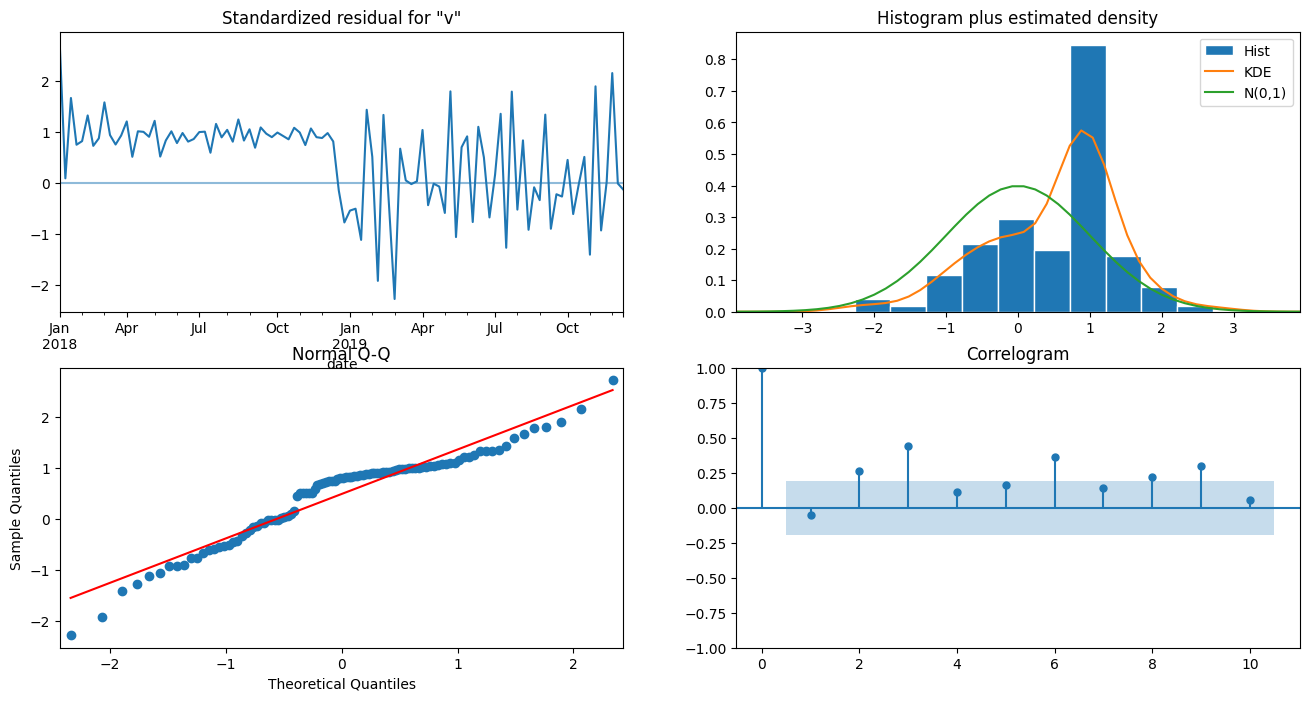

In [ ]:
model_sarima.plot_diagnostics(figsize=(16, 8))
plt.show()

### Выводы: Для бизнеса наиболее понимаемая метрика - MAPE. Которая измеряет среднюю абсолютную ошибку относительно фактических значений. В нашем baseline модель в среднем предсказывает верно на 77%. Но график показывает достаточно низкие прогнозные значения прогноза на тестовой выборке

## 2.3 Попробуем добавить фичи. В первом случае это будут временные метки. Во втором случае кодирование категориальных переменных с удалением аномалии во временных данных.

### Временные фичи

In [ ]:

class SARIMAFeatureEngineering:
    """
    Класс для генерации признаков для модели SARIMA.
    Args:
        data (pd.DataFrame): Исходные данные.
        key_cols (list): Список категориальных признаков.
        target_col (str): Имя целевого столбца.
    Attributes:
        data (pd.DataFrame): Исходные данные.
        target_col (str): Имя целевого столбца.

    Methods:
        transform(): Применяет генерацию признаков к исходным данным.
    """
    def __init__(self, data,  target_col):
        self.data = data

        self.target_col = target_col

    def _calculate_rolling_average(self, window):
        """
        Вычисляет скользящее среднее для заданного окна.

        Args:
            window (int): Размер окна для скользящего среднего.

        Returns:
            pd.Series: Скользящее среднее.
        """
        return self.data[self.target_col].rolling(window=window, min_periods=1).mean()


    def transform(self):
        """
        Генерирует признаки на основе исходных данных.

        Returns:
            pd.DataFrame: Датафрейм с новыми признаками.
        """
        # Логирование продаж за разные периоды
        self.data['log_sales_3_days'] = np.log1p(self.data[self.target_col].rolling(window=3).sum())
        self.data['log_sales_5_days'] = np.log1p(self.data[self.target_col].rolling(window=5).sum())
        self.data['log_sales_7_days'] = np.log1p(self.data[self.target_col].rolling(window=7).sum())
        self.data['log_sales_15_days'] = np.log1p(self.data[self.target_col].rolling(window=15).sum())

        # Средние продаж за разные периоды
        self.data['rolling_avg_3_days'] = self._calculate_rolling_average(window=3)
        self.data['rolling_avg_5_days'] = self._calculate_rolling_average(window=5)
        self.data['rolling_avg_7_days'] = self._calculate_rolling_average(window=7)
        self.data['rolling_avg_15_days'] = self._calculate_rolling_average(window=15)
        self.data['rolling_avg_month'] = self._calculate_rolling_average(window=30)

        # Экспоненциальные средние продаж
        self.data['ema_3_days'] = self.data[self.target_col].ewm(alpha=0.3, adjust=False).mean()
        self.data['ema_5_days'] = self.data[self.target_col].ewm(alpha=0.5, adjust=False).mean()
        self.data['ema_7_days'] = self.data[self.target_col].ewm(alpha=0.7, adjust=False).mean()
        self.data['ema_15_days'] = self.data[self.target_col].ewm(alpha=0.15, adjust=False).mean()




        return self.data

In [ ]:
df_2 = copy.deepcopy(train_plot)
df_2.head()

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,volume
date,,,,,,,,,,,
2018-01-01,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,43.0
2018-01-02,197,0,Китай,Китай,16350,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,95.0
2018-01-02,794,2162,Казахстан,Атырауская обл.,10942,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,57.0
2018-01-02,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,21.0
2018-01-02,133,0,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,150.0


In [ ]:
## преобразуем данные и добавим временные фичи
fe = SARIMAFeatureEngineering(data=df_2, target_col='volume')
df_processed = fe.transform()

In [ ]:
## Удаляем категориальные фичи
cat_cols = ["material_code", "company_code", "country", "region", "manager_code", "month", "contract_type", 'material_lvl1_name', 'material_lvl2_name', 'material_lvl3_name']
df_processed.drop(cat_cols, axis=1, inplace=True)


In [ ]:
df_resampled = df_processed.resample(rule='W').mean()
df_resampled

,volume,log_sales_3_days,log_sales_5_days,log_sales_7_days,log_sales_15_days,rolling_avg_3_days,rolling_avg_5_days,rolling_avg_7_days,rolling_avg_15_days,rolling_avg_month,ema_3_days,ema_5_days,ema_7_days,ema_15_days
date,,,,,,,,,,,,,,
2018-01-07,55.746988,4.639318,5.192213,5.531911,6.249389,52.522088,50.053012,49.309352,51.085413,56.311839,50.867160,53.285754,54.888644,48.500181
2018-01-14,37.730659,4.516626,5.091238,5.461906,6.288856,38.607450,39.190831,39.363897,39.062655,38.835244,38.834860,38.354245,37.966944,39.042563
2018-01-21,39.874773,4.522793,5.090048,5.466053,6.302050,39.802178,39.611252,39.564169,39.984029,40.286509,39.714693,39.776349,39.841227,39.835979
2018-01-28,32.554711,4.435006,4.986128,5.346487,6.147720,32.554711,32.724316,32.791793,32.859777,32.731662,32.693813,32.604965,32.562322,32.770800
2018-02-04,33.225743,4.453354,5.005602,5.365296,6.163602,33.168977,33.142574,33.151909,33.122508,33.258746,33.168865,33.193548,33.216575,33.169709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-05,39.963158,4.580558,5.138640,5.497270,6.302660,39.970175,39.971579,39.981955,40.074474,40.214079,39.985858,39.976407,39.974330,40.042080
2020-07-12,33.828283,4.444888,5.003023,5.364685,6.166530,33.806397,33.822222,33.824315,33.754882,33.619318,33.809275,33.810371,33.811319,33.769096
2020-07-19,39.692029,4.566288,5.125444,5.488783,6.299143,39.718599,39.719565,39.722740,39.767552,39.783454,39.722051,39.712443,39.705467,39.744863


In [ ]:
train_eval_fe = df_resampled[:-33]
test_eval_fe = df_resampled[-33:]
print(f"Количество недель в тренировочной выборке: {len(train_eval_fe)}")
print(f"Количество недель в тестовой выборке: {len(test_eval_fe)}")

Количество недель в тренировочной выборке: 102
Количество недель в тестовой выборке: 33


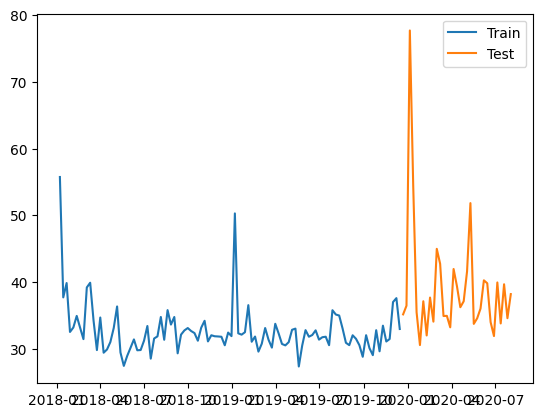

In [ ]:
plt.plot(train_eval_fe['volume'], label='Train')
plt.plot(test_eval_fe['volume'], label='Test')
plt.legend()

In [ ]:
fe_col = ['log_sales_3_days', 'log_sales_5_days', 'log_sales_7_days', 'log_sales_15_days','log_sales_15_days' ,'rolling_avg_3_days','rolling_avg_5_days','rolling_avg_7_days','rolling_avg_15_days','rolling_avg_month','ema_3_days','ema_5_days','ema_7_days','ema_15_days']

In [ ]:
## добавляем данные по временным фичас
auto_arima(train_eval_fe['volume'],
           exogenous=train_eval_fe[['log_sales_3_days', 'log_sales_5_days', 'log_sales_7_days', 'log_sales_15_days','log_sales_15_days' ,'rolling_avg_3_days','rolling_avg_5_days','rolling_avg_7_days','rolling_avg_15_days','rolling_avg_month','ema_3_days','ema_5_days','ema_7_days','ema_15_days']], seasonal=True, m=52,
                              error_action='ignore', suppress_warnings=True, stepwise=True)

ARIMA(order=(0, 0, 2), scoring_args={}, seasonal_order=(1, 0, 0, 52),
      suppress_warnings=True)

In [ ]:
model_sarima_fe = SARIMAX(train_eval_fe['volume'],
                          exog=train_eval_fe[['log_sales_3_days', 'log_sales_5_days', 'log_sales_7_days', 'log_sales_15_days','log_sales_15_days' ,'rolling_avg_3_days','rolling_avg_5_days','rolling_avg_7_days','rolling_avg_15_days','rolling_avg_month','ema_3_days','ema_5_days','ema_7_days','ema_15_days']], order=(0,0,2),seasonal_order=(1,0,0,52)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


In [ ]:
start_fe=len(train_eval_fe)
end_fe=len(train_eval_fe)+len(test_eval_fe)-1
pred_sarima_fe = model_sarima_fe.predict(start=start_fe, end=end_fe,
                                      exog = test_eval_fe[['log_sales_3_days', 'log_sales_5_days', 'log_sales_7_days', 'log_sales_15_days','log_sales_15_days' ,'rolling_avg_3_days','rolling_avg_5_days','rolling_avg_7_days','rolling_avg_15_days','rolling_avg_month','ema_3_days','ema_5_days','ema_7_days','ema_15_days']],
                                      dynamic=False)

In [ ]:
print("MAE:", MAE(pred_sarima_fe, test_eval_fe['volume']))
print("RMSE:", MSE(pred_sarima_fe, test_eval_fe['volume'])**0.5)
print("MAPE:", MAPE(pred_sarima_fe, test_eval_fe['volume']))

MAE: 0.006182713476600942
RMSE: 0.011311453487534337
MAPE: 0.0001347923615936082


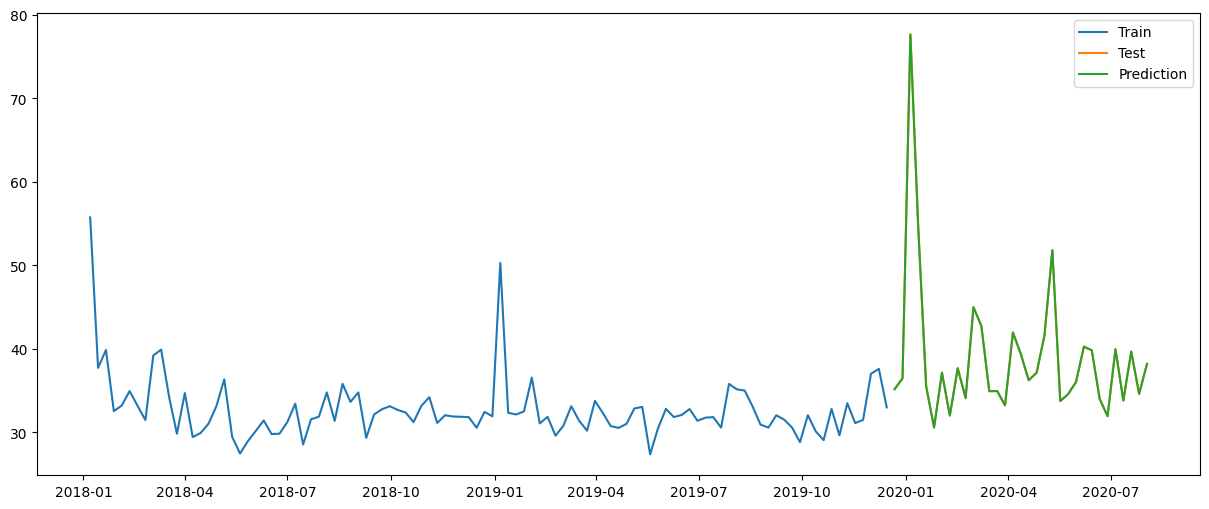

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(train_eval_fe['volume'], label='Train')
plt.plot(test_eval_fe['volume'], label='Test')
plt.plot(pred_sarima_fe, label='Prediction')
plt.legend()

## Слишком детальные временные фичи привели к dataleak, что видно на графике.

### Категориальные фичи и удаление аномалии

In [ ]:
class SARIMAFeatureEngineering_cat:
    def __init__(self, data, key_cols, target_col):
        self.data = data
        self.key_cols = key_cols
        self.target_col = target_col


    def encode_categorical_features(self):

        for col in self.key_cols:
            le = LabelEncoder()
            self.data[col] = le.fit_transform(self.data[col])

    def transform(self):

        self.encode_categorical_features()


        return self.data

In [ ]:
df_3 = copy.deepcopy(train_plot)
df_3.head()

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,volume
date,,,,,,,,,,,
2018-01-01,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,43.0
2018-01-02,197,0,Китай,Китай,16350,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,95.0
2018-01-02,794,2162,Казахстан,Атырауская обл.,10942,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,57.0
2018-01-02,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,21.0
2018-01-02,133,0,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,150.0


In [ ]:
key_cols = ["material_code", "company_code", "country", "region", "manager_code", "month", "contract_type", 'material_lvl1_name', 'material_lvl2_name', 'material_lvl3_name']

In [ ]:
fe = SARIMAFeatureEngineering_cat(data=df_3,key_cols = key_cols, target_col='volume')
df_processed_cat = fe.transform()
df_processed_cat

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,volume
date,,,,,,,,,,,
2018-01-01,2,0,12,39,10,0,0,3,2,2,43.0
2018-01-02,10,0,11,33,33,0,0,3,2,2,95.0
2018-01-02,73,40,9,3,4,0,0,1,1,1,57.0
2018-01-02,2,0,12,39,10,0,0,3,2,2,21.0
2018-01-02,1,0,11,33,44,0,0,3,2,2,150.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31,2,0,23,84,49,30,0,3,2,2,21.0
2020-07-31,41,0,16,67,32,30,0,1,1,2,3.0
2020-07-31,17,161,15,54,37,30,0,1,1,1,25.0


In [ ]:
df_resampled_cat = df_processed_cat.resample(rule='W').mean()
df_resampled_cat

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,volume
date,,,,,,,,,,,
2018-01-07,23.180723,77.156627,16.915663,56.795181,27.301205,0.000000,0.855422,2.638554,2.506024,0.903614,55.746988
2018-01-14,29.022923,82.002865,15.441261,57.825215,23.911175,0.000000,0.375358,1.859599,1.816619,1.171920,37.730659
2018-01-21,31.798548,73.584392,15.274047,57.081670,23.504537,0.000000,0.430127,1.889292,1.834846,1.201452,39.874773
2018-01-28,29.410334,70.761398,17.121581,60.314590,25.223404,0.000000,0.623100,2.268997,2.126140,1.007599,32.554711
2018-02-04,30.512871,73.538614,17.409901,61.231683,25.134653,0.291089,0.584158,2.265347,2.097030,1.037624,33.225743
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-05,38.607895,79.467105,15.964474,57.596053,24.232895,29.444737,0.281579,1.731579,1.667105,1.192105,39.963158
2020-07-12,35.161616,81.507576,15.756313,55.051768,22.630051,30.000000,0.276515,1.760101,1.643939,1.142677,33.828283
2020-07-19,36.144928,78.202899,15.647343,56.157005,23.675121,30.000000,0.326087,1.771739,1.699275,1.161836,39.692029


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


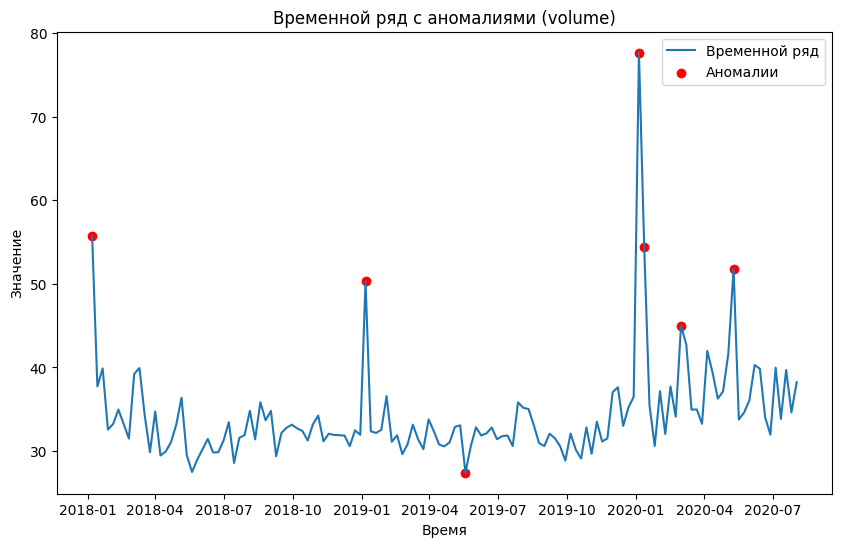

In [ ]:
## смотрим еще раз на аномалий
detect_and_plot_anomalies(df_resampled_cat, column_name='volume')

In [ ]:
## код для удаления аномалий
def remove_detected_anomalies(df, column_name):

    model = IsolationForest(contamination=0.05)
    model.fit(df[[column_name]])

    df["IsAnomaly"] = model.predict(df[[column_name]])

    df_cleaned = df[df["IsAnomaly"] != -1]

    return df_cleaned

In [ ]:
# Call the function to remove anomalies
df_cleaned = remove_detected_anomalies(df_resampled_cat, "volume")

In [ ]:
df_cleaned.drop(columns=['IsAnomaly'], inplace=True)

In [ ]:
train_eval_cat = df_cleaned[:-33]
test_eval_cat = df_cleaned[-33:]
len(train_eval_cat)

95

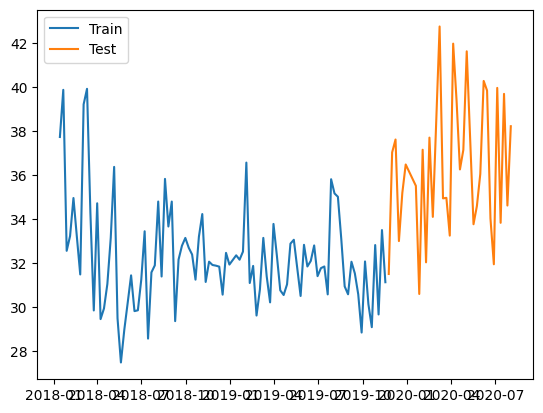

In [ ]:
plt.plot(train_eval_cat['volume'], label='Train')
plt.plot(test_eval_cat['volume'], label='Test')
plt.legend()

In [ ]:
auto_arima(train_eval_cat['volume'], exog= train_eval_cat[["material_code", "company_code", "country", "region", "manager_code", "month", "contract_type", 'material_lvl1_name', 'material_lvl2_name', 'material_lvl3_name']], seasonal = True, m=52)

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 52),
      suppress_warnings=True)

In [ ]:
model_sarima_cat = SARIMAX(train_eval_cat['volume'],
                          exog=train_eval_cat[["material_code", "company_code", "country", "region", "manager_code", "month", "contract_type", 'material_lvl1_name', 'material_lvl2_name', 'material_lvl3_name']], order=(1,0,0),seasonal_order=(0,0,0,52)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  def _init_dates(self, dates=None, freq=None):
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  def _init_dates(self, dates=None, freq=None):
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


In [ ]:
start_cat=len(train_eval_cat)
end_cat=len(train_eval_cat)+len(test_eval_cat)-1
pred_sarima_cat = model_sarima_cat.predict(start=start_cat, end=end_cat,
                                      exog = test_eval_cat[["material_code", "company_code", "country", "region", "manager_code", "month", "contract_type", 'material_lvl1_name', 'material_lvl2_name', 'material_lvl3_name']],
                                      dynamic=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  end,
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  end,


In [ ]:
print("MAE:", MAE(pred_sarima_cat, test_eval_cat['volume']))
print("RMSE:", MSE(pred_sarima_cat, test_eval_cat['volume'])**0.5)
print("MAPE:", MAPE(pred_sarima_cat, test_eval_cat['volume']))

MAE: 3.860398142514323
RMSE: 4.914493930917667
MAPE: 0.11939257657529909


In [ ]:
pred_sarima_cat.index = test_eval_cat.index ## сбился индекс

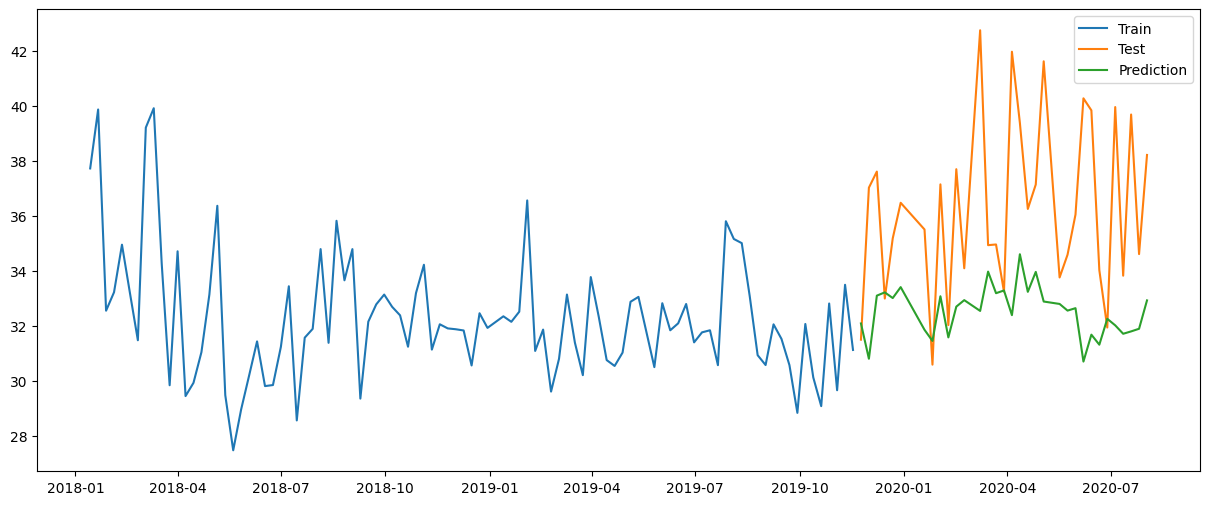

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(train_eval_cat['volume'], label='Train')
plt.plot(test_eval_cat['volume'], label='Test')
plt.plot(pred_sarima_cat, label='Prediction')
plt.legend()

##3.Строим прогноза на основе библиотеки ENTA, в которой есть уже prophet и catboost

### 3.1 Модель prophet

In [ ]:
df_4 = copy.deepcopy(train_plot)
df_4.head()

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,volume
date,,,,,,,,,,,
2018-01-01,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,43.0
2018-01-02,197,0,Китай,Китай,16350,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,95.0
2018-01-02,794,2162,Казахстан,Атырауская обл.,10942,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,57.0
2018-01-02,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,21.0
2018-01-02,133,0,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,150.0


In [ ]:
key_cols = ["material_code", "company_code", "country", "region", "manager_code", "month", "contract_type", 'material_lvl1_name', 'material_lvl2_name', 'material_lvl3_name']

In [ ]:
df_4.drop(key_cols, axis=1, inplace=True)
df_resampled_enta = df_4.resample(rule='w').mean()
df_resampled_enta

,volume
date,
2018-01-07,55.746988
2018-01-14,37.730659
2018-01-21,39.874773
2018-01-28,32.554711
2018-02-04,33.225743
...,...
2020-07-05,39.963158
2020-07-12,33.828283
2020-07-19,39.692029


In [ ]:
df_resampled_enta = df_resampled_enta.reset_index()
print(df_resampled_enta.columns)

Index(['date', 'volume'], dtype='object')


ETNA имеет строгий формат данных:
 - tagret
 - timestamp
 - segment - потому что этна всегда готова работать с несколькими временными рядами, сегмент колонки также обязателен

In [ ]:
df_resampled_enta["timestamp"] = pd.to_datetime(df_resampled_enta["date"])
df_resampled_enta["target"] = df_resampled_enta["volume"]
df_resampled_enta.drop(columns=["date", "volume"], inplace=True)
df_resampled_enta["segment"] = "main"
df_resampled_enta.head()

,timestamp,target,segment
0,2018-01-07,55.746988,main
1,2018-01-14,37.730659,main
2,2018-01-21,39.874773,main
3,2018-01-28,32.554711,main
4,2018-02-04,33.225743,main


In [ ]:
df_etna = TSDataset.to_dataset(df_resampled_enta)
df_etna.head()

segment,main
feature,target
timestamp,
2018-01-07,55.746988
2018-01-14,37.730659
2018-01-21,39.874773
2018-01-28,32.554711
2018-02-04,33.225743


In [ ]:
ts = TSDataset(df_etna, freq="W")

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(


In [ ]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: W
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2018-01-07    2020-08-02     135            0


In [ ]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2018-01-07,2020-08-02,135,0,1,0,0,0,W


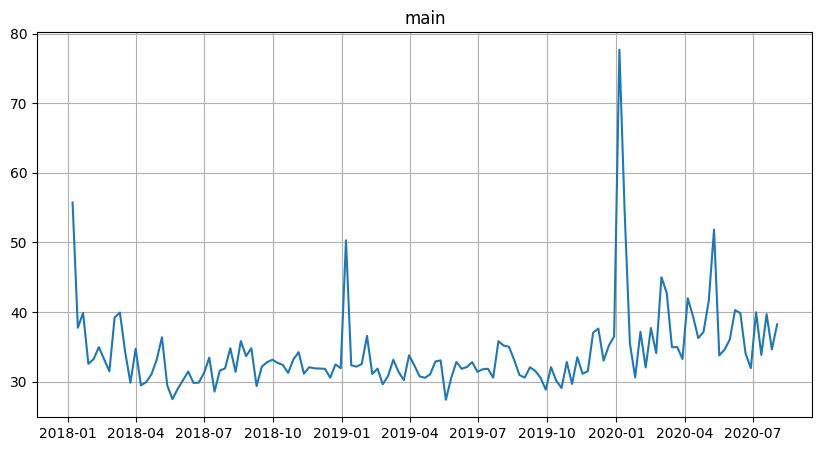

In [ ]:
ts.plot()

In [ ]:
train_ts, test_ts = ts.train_test_split(
    train_start="2018-01-07",
    train_end="2020-01-07",
    test_start="2020-01-08",
    test_end="2020-08-02",
)

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(


In [ ]:
model = ProphetModel()
model.fit(train_ts)

HORIZON = 30

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmple9mqgkn/currujku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmple9mqgkn/_ppfb89a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75499', 'data', 'file=/tmp/tmple9mqgkn/currujku.json', 'init=/tmp/tmple9mqgkn/_ppfb89a.json', 'output', 'file=/tmp/tmple9mqgkn/prophet_modelfbb734l7/prophet_model-20240301114655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:46:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:46:55 - cmdstanpy - INFO - Chain

In [ ]:
# Make the forecast
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:282: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(


In [ ]:
mae = MAE()
mae(y_true=test_ts, y_pred=forecast_ts)

{'main': 4.000308259056128}

In [ ]:
mse = MSE()
mse(y_true=test_ts, y_pred=forecast_ts)

{'main': 35.21927171240926}

In [ ]:
mape = MAPE()
mape(y_true=test_ts, y_pred=forecast_ts)

{'main': 9.581371900016002}

In [ ]:
from etna.analysis import plot_forecast

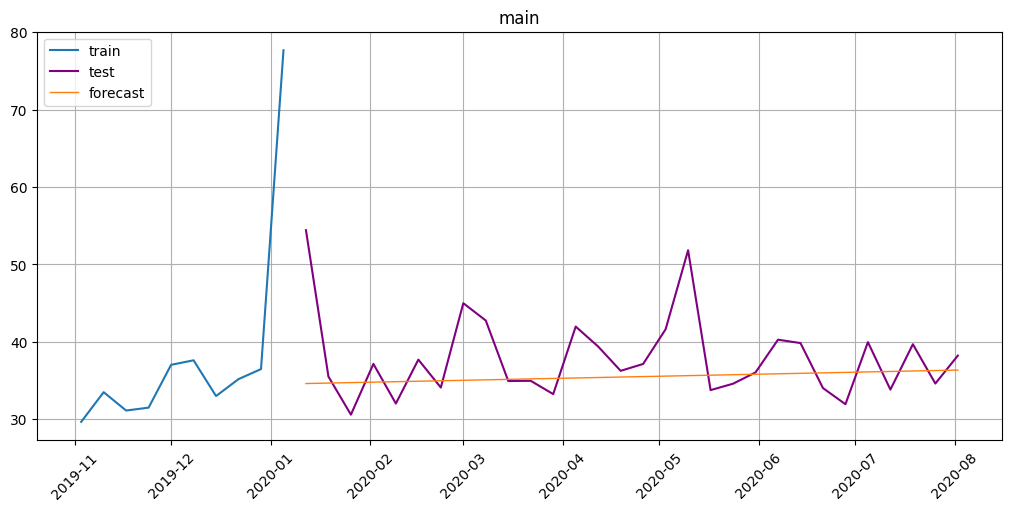

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

## Как видем из метрик и графика, хотя базовая модель prophet показывает относительно низкую ошибку, вместе с тем, на графике заметно, что прогноз продаж является усредненными значениями теста

## 3.2 Модель Catboost

In [ ]:
from etna.transforms import LagTransform, LogTransform

lags = LagTransform(in_column="target", lags=list(range(8, 24, 1)))
log = LogTransform(in_column="target")
transforms = [log, lags]
train_ts.fit_transform(transforms)

In [ ]:
from etna.models import CatBoostMultiSegmentModel

model = CatBoostMultiSegmentModel()
model.fit(train_ts)
future_ts = train_ts.make_future(future_steps=HORIZON, transforms=transforms)
forecast_ts = model.forecast(future_ts)
forecast_ts.inverse_transform(transforms)

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:282: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(


In [ ]:
mae = MAE()
mae(y_true=test_ts, y_pred=forecast_ts)

{'main': 5.159105519027772}

In [ ]:
mape = MAPE()
mape(y_true=test_ts, y_pred=forecast_ts)

{'main': 12.347942946777192}

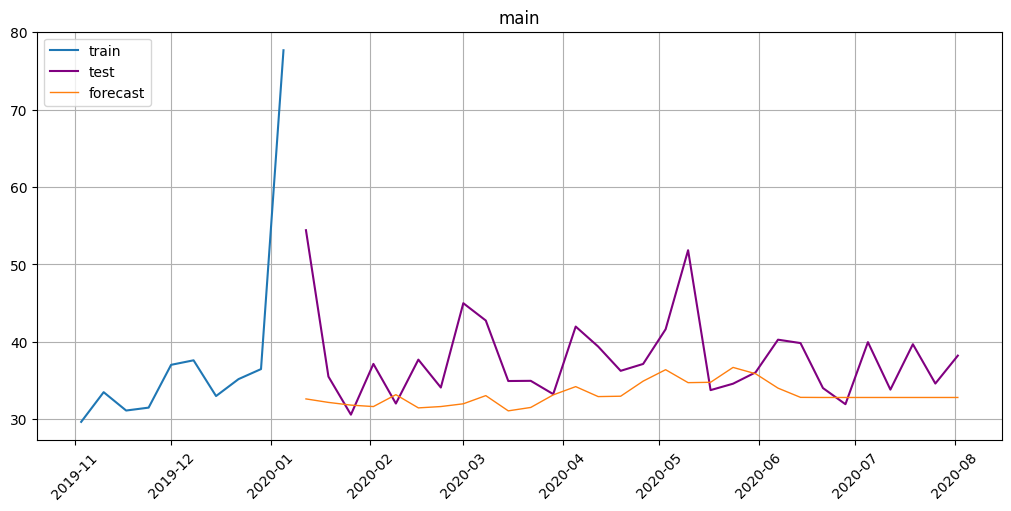

In [ ]:
train_ts.inverse_transform(transforms)
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

Основные результаты анализа. Ориентируемся на метрику MAPE:

**Models:**
- `Sarimax`: 23.4
- `Sarimax` с удалением аномалии кодированием категориальных фичей: 11.9
- `Prophet ETNA` базовая без преобразований: 9,58
- `Catboost ETNA` базовая без преобразований: 12,34


✅ Выводы:
- самая низкая ошибка у модели Prophet
- только удаление аномалии и кодирование категориальных фичей позволило SARIMAX приблизиться по ошибке к библиотеке ETNA
- визуально модели Catboost и Sarimax с преобразованием отражают наиболее адекватные данные

Требуется:
- дальнейшее исследование в части модели Catboost с удалением аномальных значений